<a href="https://colab.research.google.com/github/And2300/IA025_2022S1/blob/main/Aula6_Exerc%C3%ADcio_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [20]:
nome = 'Andersson Romero'

print(f'Meu nome é {nome}')

Meu nome é Andersson Romero


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [22]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [23]:
batch_size = 50

## Download do CIFAR-10

In [24]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [25]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [26]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

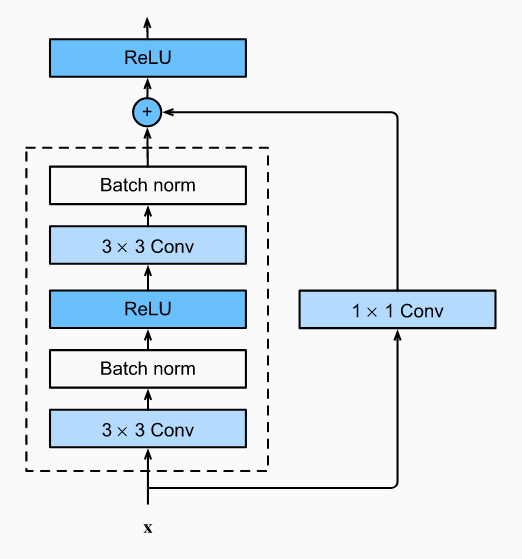

In [27]:
from torch import nn
from torch import Tensor
import torch.nn.functional as F


class MyBasicBlock(nn.Module):
#https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride
        self.downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, 
                                    groups=1, bias=False, dilation=1)

    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        out_0 = self.conv1(x)
        out_0 = self.bn1(out_0)
        out_0 = F.relu(out_0)
        out_0 = self.conv2(out_0)
        out_0 = self.bn2(out_0)

        down = self.downsample(x)
        #print('out_0:', out_0.shape, '\n','down:', down.shape)

        out = F.relu(out_0 + down)

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [28]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

target_out = block_pt(x)
print(f'target_out:\n{target_out}')
out = block(x)
print(f'out:\n{out}')

assert torch.allclose(out, target_out, atol=1e-6)

target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [31]:
class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # Escreva seu código aqui.
        self.basicblock1 = MyBasicBlock(inplanes=3, planes=64, stride=stride)
        self.basicblock2 = MyBasicBlock(inplanes=64, planes=64, stride=stride)
        self.basicblock3 = MyBasicBlock(inplanes=64, planes=64, stride=stride)
        self.pool = nn.AdaptiveAvgPool2d(1) #https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
        self.linear = nn.Linear(64,10)

    def forward(self, x):
        # Escreva seu código aqui.
        out = self.basicblock1(x)
        out = self.basicblock2(out)
        out = self.basicblock3(out)
        out = self.pool(out).squeeze()
        out = self.linear(out)
        return out

## Treinamento

### Definição dos hiperparâmetros

In [32]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
def evaluation(model, loader):
    # Escreva seu código aqui.
    cpred = []

    model.eval()
    for x, y in tqdm(loader, total=len(loader), desc='Evaluating'):  #https://www.codegrepper.com/code-examples/python/frameworks/file-path-in-python/tqdm%28total+%3D+len%28loader%29%2C+desc%3D%27Training%27%29
        x , y = x.to(device) , y.to(device)
        out = model(x)
        cpred.extend((out.argmax(dim=1) == y).tolist())
    mean_accuracy = np.mean(cpred)
    print(f'\n Accuracy: {mean_accuracy * 100:.3f}%')

### Laço de treinamento

In [35]:
from tqdm import tqdm

model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Evaluating: 100%|██████████| 200/200 [00:02<00:00, 82.45it/s]



 Accuracy: 9.950%


Training: 100%|██████████| 800/800 [00:13<00:00, 57.47it/s]


Epoch: 0/19 Loss: 1.6955715417861938


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 81.74it/s]



 Accuracy: 41.540%


Training: 100%|██████████| 800/800 [00:14<00:00, 56.35it/s]


Epoch: 1/19 Loss: 1.2129961252212524


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 84.02it/s]



 Accuracy: 54.010%


Training: 100%|██████████| 800/800 [00:14<00:00, 54.47it/s]


Epoch: 2/19 Loss: 1.164556622505188


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 81.90it/s]



 Accuracy: 52.950%


Training: 100%|██████████| 800/800 [00:14<00:00, 54.58it/s]


Epoch: 3/19 Loss: 0.8805201649665833


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 78.44it/s]



 Accuracy: 56.130%


Training: 100%|██████████| 800/800 [00:15<00:00, 52.30it/s]


Epoch: 4/19 Loss: 0.8726173639297485


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 75.15it/s]



 Accuracy: 61.300%


Training: 100%|██████████| 800/800 [00:14<00:00, 55.03it/s]


Epoch: 5/19 Loss: 0.98225998878479


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 80.91it/s]



 Accuracy: 66.990%


Training: 100%|██████████| 800/800 [00:14<00:00, 54.63it/s]


Epoch: 6/19 Loss: 0.7976348400115967


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 80.87it/s]



 Accuracy: 69.170%


Training: 100%|██████████| 800/800 [00:14<00:00, 55.81it/s]


Epoch: 7/19 Loss: 0.669857919216156


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 82.03it/s]



 Accuracy: 66.970%


Training: 100%|██████████| 800/800 [00:14<00:00, 56.62it/s]


Epoch: 8/19 Loss: 0.7364568114280701


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 82.95it/s]



 Accuracy: 67.400%


Training: 100%|██████████| 800/800 [00:14<00:00, 56.14it/s]


Epoch: 9/19 Loss: 0.764983594417572


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 82.00it/s]



 Accuracy: 69.210%


Training: 100%|██████████| 800/800 [00:14<00:00, 55.10it/s]


Epoch: 10/19 Loss: 0.7962687015533447


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 75.48it/s]



 Accuracy: 68.680%


Training: 100%|██████████| 800/800 [00:15<00:00, 52.93it/s]


Epoch: 11/19 Loss: 0.5457087755203247


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 77.07it/s]



 Accuracy: 70.190%


Training: 100%|██████████| 800/800 [00:14<00:00, 53.83it/s]


Epoch: 12/19 Loss: 0.6233651638031006


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 76.77it/s]



 Accuracy: 68.070%


Training: 100%|██████████| 800/800 [00:14<00:00, 55.62it/s]


Epoch: 13/19 Loss: 0.3485777676105499


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 80.66it/s]



 Accuracy: 69.000%


Training: 100%|██████████| 800/800 [00:14<00:00, 55.17it/s]


Epoch: 14/19 Loss: 0.29645147919654846


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 79.56it/s]



 Accuracy: 68.470%


Training: 100%|██████████| 800/800 [00:14<00:00, 55.91it/s]


Epoch: 15/19 Loss: 0.14180397987365723


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 78.15it/s]



 Accuracy: 69.690%


Training: 100%|██████████| 800/800 [00:14<00:00, 54.94it/s]


Epoch: 16/19 Loss: 0.18246792256832123


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 77.55it/s]



 Accuracy: 70.150%


Training: 100%|██████████| 800/800 [00:14<00:00, 55.36it/s]


Epoch: 17/19 Loss: 0.1965460330247879


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 81.73it/s]



 Accuracy: 69.750%


Training: 100%|██████████| 800/800 [00:14<00:00, 55.82it/s]


Epoch: 18/19 Loss: 0.33307185769081116


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 81.21it/s]



 Accuracy: 67.490%


Training: 100%|██████████| 800/800 [00:14<00:00, 54.75it/s]


Epoch: 19/19 Loss: 0.28383028507232666


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 76.69it/s]



 Accuracy: 68.840%


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

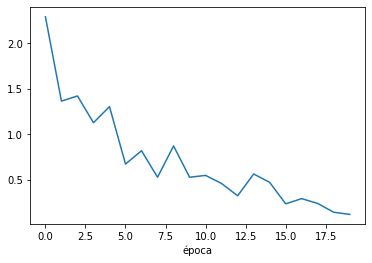

In [36]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [37]:
evaluation(model=model, loader=test_dataloader)

Evaluating: 100%|██████████| 200/200 [00:02<00:00, 76.18it/s]


 Accuracy: 68.730%


# Bonus Opcional

## Implementando o Dropout

In [ ]:
class MyDropout(torch.nn.Module): #https://pgaleone.eu/deep-learning/regularization/2017/01/10/anaysis-of-dropout/
    def __init__(self, p: float):
        # Escreva seu código aqui.
        super(MyDropout, self).__init__()
        self.p = p

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        binomial = torch.distributions.binomial.Binomial(probs=1-self.p)
        out = x*binomial.sample(x.size()) * (1.0/(1-self.p))

        return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [ ]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.4984944760799408
mean zeros pytorch: 0.5003458857536316


AssertionError: ignored